In [10]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Delta_x = 1.0
Delta_t = 0.2
kappa = 0.5
拡散数dは d = kappa * Delta_t / Delta_x ** 2
d = 0.1


(100.0, 200.0)

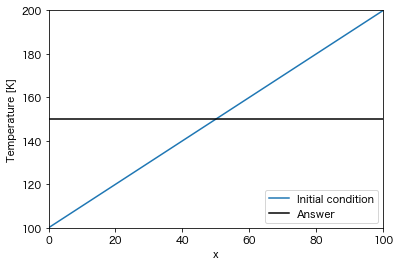

In [11]:
Num_stencil_x = 101
# print(Num_stencil_x)
x_array = np.float64(np.arange(Num_stencil_x))
# print(x_array)
temperature_array = x_array + 100
# print(temperature_array)
temperature_lower_boundary = 150
# print(temperature_lower_boundary)
temperature_upper_boundary = 150
# print(temperature_lower_boundary)
Time_step = 100
Delta_x = max(x_array) / (Num_stencil_x - 1)
print(f'Delta_x = {Delta_x}')
Delta_t = 0.2
print(f'Delta_t = {Delta_t}')
kappa = 0.5
print(f'kappa = {kappa}')
# 拡散数dはd = kappa * Delta_t / Delta_x ** 2
print("拡散数dは d = kappa * Delta_t / Delta_x ** 2")
d = kappa * Delta_t / Delta_x ** 2
print(f'd = {d}')
exact_temperature_array = (temperature_upper_boundary - temperature_lower_boundary) / (x_array[-1] - x_array[0]) * x_array + temperature_lower_boundary

# print(exact_temperature_array)
plt.plot(x_array, temperature_array, label="Initial condition")
plt.plot(x_array, exact_temperature_array, label="Answer", c="black")
plt.legend(loc="lower right")
plt.xlabel("x")
plt.ylabel("Temperature [K]")
plt.xlim(0, max(x_array))
plt.ylim(100, 200)


# numpyを用いずにフルスクラッチで実装

(100.0, 200.0)

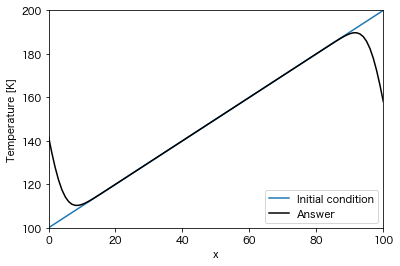

In [12]:
temperature_explicit = temperature_array.copy()
# print(temperature_explicit)
for n in range(Time_step):
    temperature_old = temperature_explicit.copy()
    temperature_explicit[0] += kappa * Delta_t / Delta_x ** 2 * \
        (temperature_explicit[1]  -2 * temperature_old[0] + temperature_lower_boundary)
    temperature_explicit[-1] += kappa * Delta_t / Delta_x ** 2 * \
        (temperature_upper_boundary - 2 * temperature_old[-1] + temperature_old[-2])
    for j in range(1, Num_stencil_x - 1):
        temperature_explicit[j] += kappa * Delta_t / Delta_x ** 2 * \
            (temperature_old[j + 1] - 2 * temperature_old[j] + temperature_old[j - 1])

# print(exact_temperature_array)
plt.plot(x_array, temperature_array, label="Initial condition")
plt.plot(x_array, temperature_explicit, label="Answer", c="black")
plt.plot(x_array, exact_temperature_array, label="Answer", c="black")
plt.legend(loc="lower right")
plt.xlabel("x")
plt.ylabel("Temperature [K]")
plt.xlim(0, max(x_array))
plt.ylim(100, 200)

# Jacobi法

In [13]:
def jacobi(a_matrix, b_array, target_residual):
    """
    ヤコビ法
    Ax = b
    A = (D+L+U)とすると
    Dx = b - (L+U)x
    x = D^{-1} (b - (L+U)x)
    ただし、Dは対角行列、L+Uはその残余行列とする。

    Parameters
    ----------
    a_matrix : numpy.float64
        m×nの行列
    b_array : numpy.float64
        m行の行列
    target_residual : numpy.float64
        正の数。目標とする残差。

    Returns
    -------
    x : numpy.float64
        m行の行列
    """
    x = b_array.copy()
    x_old = b_array.copy()

    diag_matrix= np.diag(a_matrix)  # 対角行列
    l_u_matrix = a_matrix - np.diagflat(diag_matrix)  # 残余行列
    count = 0
    while True:
        count += 1
        x = (b_array - np.dot(l_u_matrix, x_old))/diag_matrix
        residual = np.linalg.norm(x - x_old) / np.linalg.norm(x)
        x_old = x
        if residual <= target_residual:
            break
        elif count >= 10000:
            import sys
            print(residual)
            sys.exit()
    return x

A = np.array([[ 3.0,  2.0, -0.5],
              [ 1.0,  4.0,  1.0],
              [-1.0,  0.0,  4.0]])
b = np.array([3.0, 2.0, 1.0])

x = jacobi(A, b, 10**-6)
print("Solution", x)
print("Answer", np.dot(np.linalg.inv(A),b))

Solution [1.00000063 0.12499957 0.50000029]
Answer [1.    0.125 0.5  ]


# jacobi法を用いて求解

(100.0, 200.0)

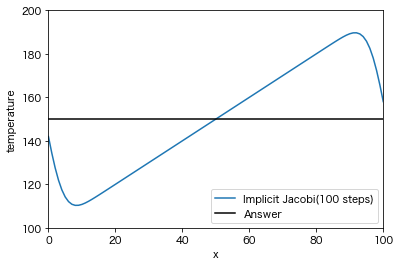

In [17]:
# 前のjacobi関数を用いている

temperature_jacobi = temperature_array.copy()
for n in range(Time_step):
    a_matrix = np.identity(len(temperature_jacobi)) * 2 *(1/d+1) \
                - np.eye(len(temperature_jacobi), k=1) \
                - np.eye(len(temperature_jacobi), k=-1)
    temp_temperature_array = np.append(np.append(
                        temperature_lower_boundary, 
                        temperature_jacobi), temperature_upper_boundary)
    b_array = 2 * (1/d - 1) * temperature_jacobi + temp_temperature_array[2:] + temp_temperature_array[:-2]
    b_array[0] += temperature_lower_boundary
    b_array[-1] += temperature_upper_boundary
    temperature_jacobi = jacobi(a_matrix, b_array, 1e-8)
plt.plot(x_array, temperature_jacobi, label="Implicit Jacobi(100 steps)")
plt.plot(x_array, exact_temperature_array, label="Answer", c="black")
plt.legend(loc="lower right")
plt.xlabel("x")
plt.ylabel("temperature")
plt.xlim(0, max(x_array))
plt.ylim(100, 200)

# gauss seidel法を用いて求解

(100.0, 200.0)

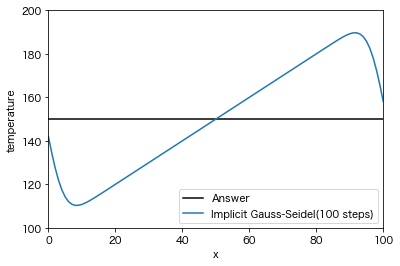

In [19]:
def gauss_seidel(a_matrix, b_array, target_residual):
    """
    Gauss-Seidel法
    Ax = b
    A = (D+L+U)とすると
    x^{(m+1)} = D^{-1}(b- L x^{(m+1)} - U x^{(m)})
    x^{(m+1)} = (D+L)^{-1}(b - U x^{(m)})
    ただし、Dは対角行列、Lは下三角行列、Uは上三角行列とする。

    Parameters
    ----------
    a_matrix : numpy.float64
        n×mの行列
    b_array : numpy.float64
        n行の行列
    target_residual : numpy.float64
        正の数。目標とする残差。

    Returns
    -------
    x : numpy.float64
        n行の行列
    """
    x_old = b_array.copy()
    lower_matrix = np.tril(a_matrix) # 下三角行列
    upper_matrix = a_matrix - lower_matrix  # 上三角行列
    inv_lower_matrix = np.linalg.inv(lower_matrix)
    count = 0
    while True:
        count += 1
        x = np.dot(inv_lower_matrix, (b_array - np.dot(upper_matrix, x_old)))
        residual = np.linalg.norm(x - x_old) / np.linalg.norm(x)
        x_old = x
        if residual <= target_residual:
            break
        elif count >= 10000:
            import sys
            print(residual)
            sys.exit()
    return x

temperature_gs = temperature_array.copy()
for n in range(Time_step):
    a_matrix = np.identity(len(temperature_gs)) * 2 *(1/d+1) \
                - np.eye(len(temperature_gs), k=1) \
                - np.eye(len(temperature_gs), k=-1)
    temp_temperature_array = np.append(np.append(
                        temperature_lower_boundary, 
                        temperature_gs), temperature_upper_boundary)
    b_array = 2 * (1/d - 1) * temperature_gs + temp_temperature_array[2:] + temp_temperature_array[:-2]
    b_array[0] += temperature_lower_boundary
    b_array[-1] += temperature_upper_boundary
    temperature_gs = gauss_seidel(a_matrix, b_array, 1e-8)
plt.plot(x_array, exact_temperature_array, label="Answer", c="black")
plt.plot(x_array, temperature_gs, label="Implicit Gauss-Seidel(100 steps)")
plt.legend(loc="lower right")
plt.xlabel("x")
plt.ylabel("temperature")
plt.xlim(0, max(x_array))
plt.ylim(100, 200)

# SOR法を用いて求解

(100.0, 200.0)

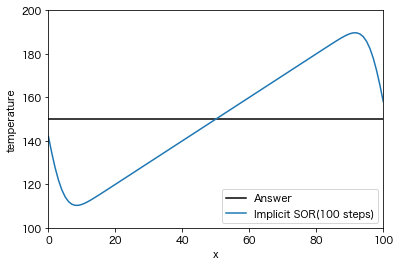

In [20]:
def sor(a_matrix, b_array, target_residual):
    """
    SOR法
    Ax = b
    A = (D+L+U)とすると
    x~^{(m+1)} = D^{-1}(b- L x^{(m+1)} - U x^{(m)}) : Gauss-Seidel
    x^{(m+1)} = x^{(m)} + omega (x~^{(m+1)} - x^{(m)})
    ただし、Dは対角行列、Lは下三角行列、Uは上三角行列とする。

    Parameters
    ----------
    a_matrix : numpy.float64
        n×mの行列
    b_array : numpy.float64
        n行の行列
    target_residual : numpy.float64
        正の数。目標とする残差。

    Returns
    -------
    x : numpy.float64
        n行の行列
    """
    x_old = b_array.copy()
    lower_matrix = np.tril(a_matrix) # 下三角行列
    upper_matrix = a_matrix - lower_matrix  # 上三角行列
    inv_lower_matrix = np.linalg.inv(lower_matrix)
    omega = 1.9  # 今回の例だと収束が遅いかもしれません。
    count = 0
    while True:
        count += 1
        x_tilde = np.dot(inv_lower_matrix, (b_array - np.dot(upper_matrix, x_old)))
        x = x_old + omega * (x_tilde - x_old)
        residual = np.linalg.norm(x - x_old) / np.linalg.norm(x)
        x_old = x
        if residual <= target_residual:
            break
        elif count >= 10000:
            import sys
            print(residual)
            sys.exit()
    return x

temperature_sor = temperature_array.copy()
for n in range(Time_step):
    a_matrix = np.identity(len(temperature_sor)) * 2 *(1/d+1) \
                - np.eye(len(temperature_sor), k=1) \
                - np.eye(len(temperature_sor), k=-1)
    temp_temperature_array = np.append(np.append(
                        temperature_lower_boundary, 
                        temperature_sor), temperature_upper_boundary)
    b_array = 2 * (1/d - 1) * temperature_sor + temp_temperature_array[2:] + temp_temperature_array[:-2]
    b_array[0] += temperature_lower_boundary
    b_array[-1] += temperature_upper_boundary
    temperature_sor = sor(a_matrix, b_array, 1e-8)
plt.plot(x_array, exact_temperature_array, label="Answer", c="black")
plt.plot(x_array, temperature_sor, label="Implicit SOR(100 steps)")
plt.legend(loc="lower right")
plt.xlabel("x")
plt.ylabel("temperature")
plt.xlim(0, max(x_array))
plt.ylim(100, 200)